In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import get_file

In [2]:
# データセットを取得する。
dataset_dir = get_file(
    "flower_photos",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    untar=True,
)
print(dataset_dir)  # /root/.keras/datasets/flower_photos

num_classes = 5

/root/.keras/datasets/flower_photos


In [3]:
# VGG16 モデルを作成する。
vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg16.trainable = False  # 重みをフリーズする。

W0804 09:41:06.951359 140129632745216 deprecation.py:506] From /root/.local/share/virtualenvs/notebook-Pv36DT_Y/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
model = Sequential(
    [
        vgg16,
        Flatten(),
        Dense(500, activation="relu"),
        Dropout(0.5),
        Dense(500, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               12544500  
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2

In [5]:
# コンパイルする。
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [6]:
# ハイパーパラメータ
batch_size = 64  # バッチサイズ
num_epochs = 30  # エポック数

# ImageDataGenerator を作成する。
datagen_params = {
    "preprocessing_function": preprocess_input,
    "horizontal_flip": True,
    "brightness_range": (0.7, 1.3),
    "validation_split": 0.2,
}
datagen = image.ImageDataGenerator(**datagen_params)

In [7]:
# 学習データを生成するジェネレーターを作成する。
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=model.input_shape[1:3],
    batch_size=batch_size,
    class_mode="sparse",
    subset="training",
)

# バリデーションデータを生成するジェネレーターを作成する。
val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=model.input_shape[1:3],
    batch_size=batch_size,
    class_mode="sparse",
    subset="validation",
)

# クラス ID とクラス名の対応関係
print(train_generator.class_indices)
# {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [8]:
# 学習する。
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=num_epochs,
)

Epoch 1/30
45/45 [==============================] - 18s 408ms/step - loss: 11.5132 - acc: 0.6181 - val_loss: 1.8184 - val_acc: 0.8224
Epoch 2/30
45/45 [==============================] - 14s 309ms/step - loss: 3.1771 - acc: 0.7673 - val_loss: 1.7345 - val_acc: 0.8153
Epoch 3/30
45/45 [==============================] - 14s 312ms/step - loss: 2.1112 - acc: 0.7899 - val_loss: 0.9347 - val_acc: 0.8253
Epoch 4/30
45/45 [==============================] - 14s 313ms/step - loss: 1.8364 - acc: 0.7892 - val_loss: 1.1957 - val_acc: 0.8139
Epoch 5/30
45/45 [==============================] - 14s 310ms/step - loss: 1.4602 - acc: 0.8302 - val_loss: 1.1365 - val_acc: 0.8239
Epoch 6/30
45/45 [==============================] - 14s 317ms/step - loss: 1.2428 - acc: 0.8296 - val_loss: 1.1582 - val_acc: 0.8139
Epoch 7/30
45/45 [==============================] - 14s 316ms/step - loss: 1.5036 - acc: 0.8226 - val_loss: 0.8859 - val_acc: 0.8210
Epoch 8/30
45/45 [==============================] - 14s 317ms/step -

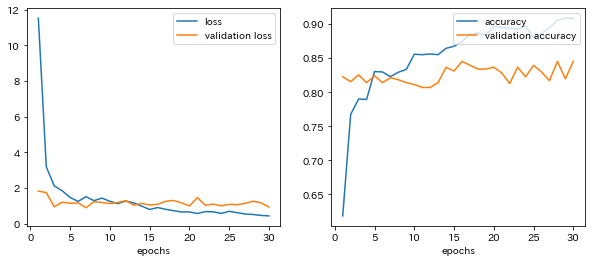

In [9]:
epochs = np.arange(1, num_epochs + 1)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))

# 損失関数の履歴を可視化する。
ax1.plot(epochs, history.history["loss"], label="loss")
ax1.plot(epochs, history.history["val_loss"], label="validation loss")
ax1.set_xlabel("epochs")
ax1.legend(loc="upper right")

# 精度の履歴を可視化する。
ax2.plot(epochs, history.history["acc"], label="accuracy")
ax2.plot(epochs, history.history["val_acc"], label="validation accuracy")
ax2.set_xlabel("epochs")
ax2.legend(loc="upper right")

plt.show()

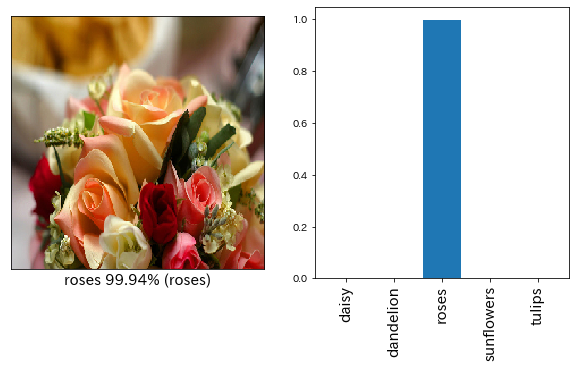

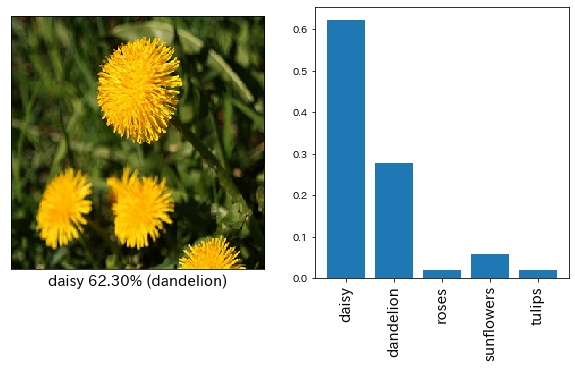

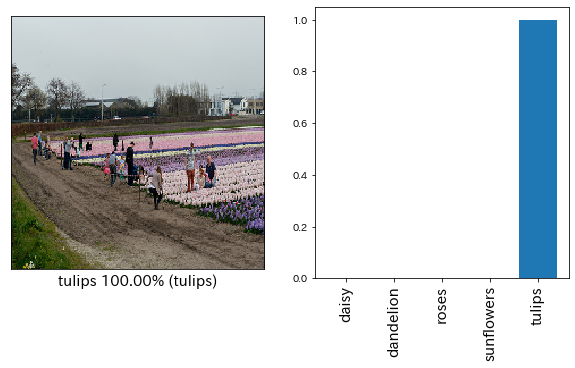

In [10]:
class_names = list(val_generator.class_indices.keys())


def plot_prediction(img, prediction, label):
    pred_label = np.argmax(prediction)

    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5), facecolor="w")

    ax1.imshow(img)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xlabel(
        f"{class_names[pred_label]} {prediction[pred_label]:.2%} ({class_names[label]})",
        fontsize=15,
    )

    bar_xs = np.arange(len(class_names))  # 棒の位置
    ax2.bar(bar_xs, prediction)
    ax2.set_xticks(bar_xs)
    ax2.set_xticklabels(class_names, rotation="vertical", fontsize=15)


# バリデーションデータから3サンプル推論して、結果を表示する。
for i in val_generator.index_array[:3]:
    img_path = val_generator.filepaths[i]
    label = val_generator.labels[i]

    # 画像を読み込む。
    img = Image.open(img_path)
    # モデルの入力サイズにリサイズする。
    img = img.resize(reversed(val_generator.target_size))
    # PIL -> numpy 配列
    img = np.array(img)
    # バッチ次元を追加する。
    x = np.expand_dims(img, axis=0)
    # 前処理を行う。
    x = preprocess_input(x)

    # 推論する。
    prediction = model.predict(x)

    # 推論結果を可視化する。
    plot_prediction(img, prediction[0], label)